# Detect forged banknotes using CNN

## Data Augmentation 

In [ ]:
#creating image dataset

In [1]:
# Data Augmentation using keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [2]:
datagen = ImageDataGenerator(rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            fill_mode = 'nearest')

In [85]:
img = load_img('Base-dataset/real/50/real50-3.jpg')
x = img_to_array(img)
x = x.reshape((1,)+ x.shape)

In [86]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i=0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='preview/real/50(Real_Front)', save_prefix ='50USD-real-F', save_format='png'):
    i += 1
    if i > 650:
        break

## Data preparation

In [2]:
#Organize data into training, validation and testing dirs
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [1]:
import splitfolders


In [3]:
input_folder = 'preview/'

splitfolders.ratio(input_folder, output="dataset",
                  seed=42, ratio=(.7, .2, .1),
                  group_prefix=None)

Copying files: 18118 files [05:40, 53.24 files/s] 


## Building the CNN model

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
#define directoris containing train, test, validate data
train_path = 'dataset/train'
vaild_path = 'dataset/val'
test_path = 'dataset/test'

In [3]:
#define number of batches the data has to be divided into
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['10(Fake_Front)','10(Real_Front)'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(vaild_path, target_size=(224,224), classes=['10(Fake_Front)','10(Real_Front)'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['10(Fake_Front)','10(Real_Front)'], batch_size=10)

Found 3188 images belonging to 2 classes.
Found 911 images belonging to 2 classes.
Found 457 images belonging to 2 classes.


In [4]:
# plots images with labels 
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2==0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
#grab btaches of data from above defined batches
imgs, labels = next(train_batches)

C:\Users\Lahiru\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


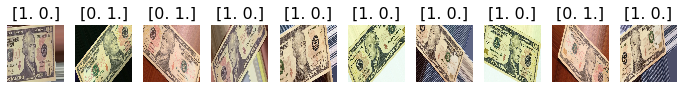

In [6]:
plots(imgs, titles=labels)

### Create the convolutional base

In [7]:
vgg16_model = keras.applications.vgg16.VGG16()

In [8]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

In [10]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [12]:
for layer in model.layers:
    layer.trainable = False

In [13]:
model.add(Dense(2, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [15]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                   validation_data = valid_batches, validation_steps=4, epochs=5, verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
4/4 - 10s - loss: 0.6925 - accuracy: 0.5000 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 2/5
4/4 - 10s - loss: 0.6952 - accuracy: 0.4500 - val_loss: 0.6897 - val_accuracy: 0.6000
Epoch 3/5
4/4 - 10s - loss: 0.6971 - accuracy: 0.3750 - val_loss: 0.6908 - val_accuracy: 0.5250
Epoch 4/5
4/4 - 11s - loss: 0.6900 - accuracy: 0.5250 - val_loss: 0.6937 - val_accuracy: 0.4500
Epoch 5/5
4/4 - 11s - loss: 0.6924 - accuracy: 0.4750 - val_loss: 0.6957 - val_accuracy: 0.4000


## Prediction

C:\Users\Lahiru\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


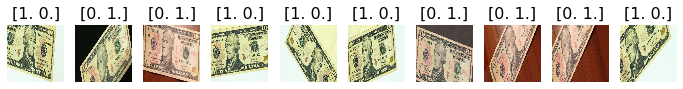

In [28]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles= test_labels)

In [29]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 0., 1., 1., 1., 0., 0., 0., 1.], dtype=float32)

In [30]:
predictions = model.predict(test_batches, steps=1, verbose=0)

In [31]:
predictions

array([[0.49261403, 0.50738597],
       [0.49177477, 0.5082252 ],
       [0.48964453, 0.5103555 ],
       [0.49474636, 0.50525373],
       [0.49401346, 0.5059866 ],
       [0.49226883, 0.5077312 ],
       [0.49364817, 0.5063519 ],
       [0.502147  , 0.49785295],
       [0.49030405, 0.5096959 ],
       [0.49838364, 0.50161636]], dtype=float32)

In [32]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

In [33]:
def plot_confusion_matrix(cm, classes, normalize=False, title= 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    #this function prints and plots the confusion matrix.
    #Normalization can be applied by setting 'normalize=True'.
    
    plt.imshow(cm, interpolation='nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2,
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[1, j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4 1]
 [5 0]]


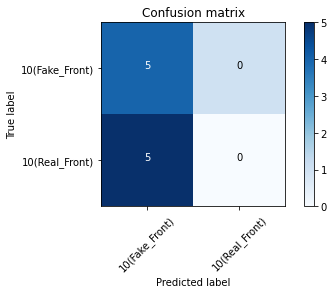

In [34]:
cm_plot_labels = ['10(Fake_Front)','10(Real_Front)']
plot_confusion_matrix(cm, cm_plot_labels, title= 'Confusion matrix')